# Notebook: fine-tune SAM (segment anything) on a custom dataset

In this notebook, we'll reproduce the [MedSAM](https://github.com/bowang-lab/MedSAM) project, which fine-tunes [SAM](https://huggingface.co/docs/transformers/main/en/model_doc/sam) on a dataset of medical images. For demo purposes, we'll use a toy dataset, but this can easily be scaled up.

Resources used to create this notebook (thanks 🙏):
* [Encode blog post](https://encord.com/blog/learn-how-to-fine-tune-the-segment-anything-model-sam/)
* [MedSAM repository](https://github.com/bowang-lab/MedSAM).

## Set-up environment

We first install 🤗 Transformers and 🤗 Datasets.

In [1]:
!pip install -q git+https://github.com/huggingface/transformers.git

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.9/2.9 MB 24.4 MB/s eta 0:00:00


In [2]:
!pip install -q datasets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 471.6/471.6 kB 8.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 8.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 39.9/39.9 MB 15.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 9.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 13.4 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
cudf-cu12 24.4.1 requires pyarrow<15.0.0a0,>=14.0.1, but you have pyarrow 17.0.0 which is incompatible.


We also install the [Monai](https://github.com/Project-MONAI/MONAI) repository as we'll use a custom loss function from it.

In [3]:
!pip install -q monai

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 8.3 MB/s eta 0:00:00


In [7]:
!pip install patchify


  Using cached patchify-0.2.3-py3-none-any.whl.metadata (3.0 kB)
Using cached patchify-0.2.3-py3-none-any.whl (6.6 kB)


## Load dataset

Here we load a small dataset of 130 (image, ground truth mask) pairs.

To load your own images and masks, refer to the bottom of my [SAM inference notebook](https://github.com/NielsRogge/Transformers-Tutorials/blob/master/SAM/Run_inference_with_MedSAM_using_HuggingFace_Transformers.ipynb).

See also [this guide](https://huggingface.co/docs/datasets/image_dataset).

In [8]:

import numpy as np
import matplotlib.pyplot as plt
# import tifffile
import os
from patchify import patchify  #Only to handle large images
import random
from scipy import ndimage


In [9]:
from datasets import load_dataset

dataset = load_dataset("scene_parse_150", split="train[:100]")


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


scene_parse_150.py:   0%|          | 0.00/21.4k [00:00<?, ?B/s]

README.md:   0%|          | 0.00/50.0k [00:00<?, ?B/s]

The repository for scene_parse_150 contains custom code which must be executed to correctly load the dataset. You can inspect the repository content at https://hf.co/datasets/scene_parse_150.
You can avoid this prompt in future by passing the argument `trust_remote_code=True`.

Do you wish to run the custom code? [y/N] y


Generating train split:   0%|          | 0/20210 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/3352 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/2000 [00:00<?, ? examples/s]

In [10]:
dataset

Dataset({
    features: ['image', 'annotation', 'scene_category'],
    num_rows: 100
})

We can visualize an example:

In [11]:
def create_ade20k_label_colormap():
  """Creates a label colormap used in ADE20K segmentation benchmark.

  Returns:
    A colormap for visualizing segmentation results.
  """
  return np.asarray([
      [0, 0, 0],
      [120, 120, 120],
      [180, 120, 120],
      [6, 230, 230],
      [80, 50, 50],
      [4, 200, 3],
      [120, 120, 80],
      [140, 140, 140],
      [204, 5, 255],
      [230, 230, 230],
      [4, 250, 7],
      [224, 5, 255],
      [235, 255, 7],
      [150, 5, 61],
      [120, 120, 70],
      [8, 255, 51],
      [255, 6, 82],
      [143, 255, 140],
      [204, 255, 4],
      [255, 51, 7],
      [204, 70, 3],
      [0, 102, 200],
      [61, 230, 250],
      [255, 6, 51],
      [11, 102, 255],
      [255, 7, 71],
      [255, 9, 224],
      [9, 7, 230],
      [220, 220, 220],
      [255, 9, 92],
      [102, 255, 255],
      [54, 67, 235],
      [220, 220, 0],
      [182, 182, 255],
      [0, 255, 255],
      [5, 0, 255],
      [183, 130, 88],
      [204, 170, 102],
      [255, 214, 0],
      [25, 194, 194],
      [102, 255, 204],
      [170, 153, 87],
      [7, 188, 255],
      [190, 190, 190],
      [255, 153, 153],
      [180, 165, 180],
      [119, 11, 32],
      [153, 153, 153],
      [150, 120, 90],
      [63, 128, 67],
      [0, 0, 230],
      [0, 0, 70],
      [0, 128, 192],
  ])



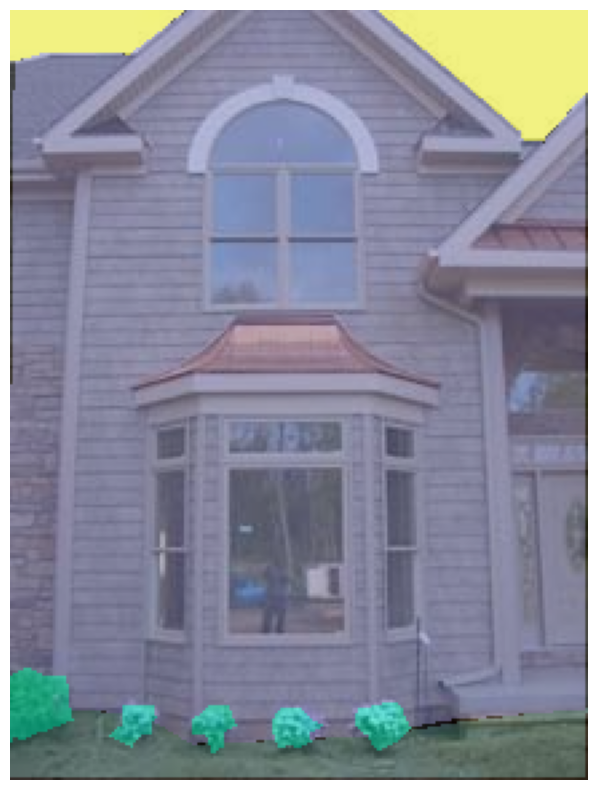

In [12]:
import matplotlib.pyplot as plt

def visualize_seg_mask(image: np.ndarray, mask: np.ndarray):
   color_seg = np.zeros((mask.shape[0], mask.shape[1], 3), dtype=np.uint8)
   palette = np.array(create_ade20k_label_colormap())
   for label, color in enumerate(palette):
       color_seg[mask == label, :] = color
   color_seg = color_seg[..., ::-1]  # convert to BGR

   img = np.array(image) * 0.5 + color_seg * 0.5  # plot the image with the segmentation map
   img = img.astype(np.uint8)

   plt.figure(figsize=(15, 10))
   plt.imshow(img)
   plt.axis("off")
   plt.show()


visualize_seg_mask(
    np.array(dataset[0]["image"]),
    np.array(dataset[0]["annotation"])
)

In [13]:
import albumentations

transform = albumentations.Compose(
    [
        albumentations.Resize(1024, 1024),
        albumentations.RandomBrightnessContrast(brightness_limit=0.3, contrast_limit=0.3, p=0.5),
    ]
)

/usr/local/lib/python3.10/dist-packages/albumentations/__init__.py:13: UserWarning: A new version of Albumentations is available: 1.4.17 (you have 1.4.15). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


In [33]:
def transforms(examples):
    transformed_images, transformed_masks = [], []
    for image, seg_mask in zip(examples["image"], examples["annotation"]):
        image, seg_mask = np.array(image), np.array(seg_mask)
        transformed = transform(image=image, mask=seg_mask)
        transformed_images.append(transformed["image"])
        transformed_masks.append(transformed["mask"])
    examples["image"] = transformed_images
    examples["annotation"] = transformed_masks
    return examples
dataset.set_transform(transforms)

In [17]:
from transformers import SamProcessor

processor = SamProcessor.from_pretrained("facebook/sam-vit-base")


The cache for model files in Transformers v4.22.0 has been updated. Migrating your old cache. This is a one-time only operation. You can interrupt this and resume the migration later on by calling `transformers.utils.move_cache()`.


0it [00:00, ?it/s]

preprocessor_config.json:   0%|          | 0.00/466 [00:00<?, ?B/s]

In [18]:
from torch.utils.data import DataLoader
from torchvision.transforms import ToTensor
import torch

# ... (rest of your code) ...

def collate_fn(batch):
    """Custom collate function to handle PIL images and annotations."""
    # Convert PIL images to tensors
    images = [ToTensor()(item['image']) for item in batch]

    # Stack images into a batch tensor
    images = torch.stack(images, dim=0)

    # Assuming 'annotation' is a PIL Image, convert to tensor and stack
    annotations = [ToTensor()(item['annotation']) for item in batch]
    annotations = torch.stack(annotations, dim=0)

    # Create a new batch dictionary
    new_batch = {'image': images, 'annotation': annotations}

    # Add other items to the batch if needed (excluding 'image' and 'annotation')
    for key in batch[0]:
        if key not in ['image', 'annotation']:
            new_batch[key] = [item[key] for item in batch]

    return new_batch

train_dataloader = DataLoader(dataset, batch_size=2, shuffle=True,collate_fn=collate_fn)

In [ ]:
from transformers import SamModel
from torch.optim import Adam
import monai
import torch
from tqdm import tqdm
from statistics import mean
from torchvision import transforms

# Load the SAM model
model = SamModel.from_pretrained("facebook/sam-vit-base")

# Freeze the vision encoder and prompt encoder
for name, param in model.named_parameters():
    if name.startswith("vision_encoder") or name.startswith("prompt_encoder"):
        param.requires_grad_(False)

# Set up optimizer and loss function
optimizer = Adam(model.mask_decoder.parameters(), lr=1e-5, weight_decay=0)
seg_loss = monai.losses.DiceCELoss(sigmoid=True, squared_pred=True, reduction='mean')

# Set up device and model
device = "cuda" if torch.cuda.is_available() else "cpu"
model.to(device)

# Define a transform to resize images to 1024x1024
resize_transform = transforms.Compose([
    transforms.Resize((1024, 1024)),
])

# Fine-tune the model
num_epochs = 10

model.train()
for epoch in range(num_epochs):
    epoch_losses = []
    for batch in tqdm(train_dataloader):
        # Resize the images to 1024x1024
        resized_images = resize_transform(batch["image"])

        # Forward pass
        outputs = model(pixel_values=resized_images.to(device),
                        input_boxes=None,  # Assuming no bounding boxes provided
                        multimask_output=False)

        # Predicted masks
        predicted_masks = outputs.pred_masks.squeeze(1)

        # Ground truth masks (resize as well if needed)
        ground_truth_masks = batch["annotation"].float().to(device)
        # ground_truth_masks_resized = resize_transform(ground_truth_masks)
        predicted_masks = resize_transform(predicted_masks)

        # Compute loss
        loss = seg_loss(predicted_masks, ground_truth_masks)

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        epoch_losses.append(loss.item())

    print(f'EPOCH: {epoch}')
    print(f'Mean loss: {mean(epoch_losses)}')


  4%|▍         | 2/50 [02:18<55:15, 69.06s/it]

## Create PyTorch dataset

Below we define a regular PyTorch dataset, which gives us examples of the data prepared in the format for the model. Each example consists of:

* pixel values (which is the image prepared for the model)
* a prompt in the form of a bounding box
* a ground truth segmentation mask.

The function below defines how to get a bounding box prompt based on the ground truth segmentation. This was taken from [here](https://github.com/bowang-lab/MedSAM/blob/66cf4799a9ab9a8e08428a5087e73fc21b2b61cd/train.py#L29).

Note that SAM is always trained using certain "prompts", which you could be bounding boxes, points, text, or rudimentary masks. The model is then trained to output the appropriate mask given the image + prompt.

## Create PyTorch DataLoader

Next we define a PyTorch Dataloader, which allows us to get batches from the dataset.



## Inference

Important note here: as we used the Dice loss with `sigmoid=True`, we need to make sure to appropriately apply a sigmoid activation function to the predicted masks. Hence we won't use the processor's `post_process_masks` method here.

In [ ]:
# apply sigmoid
medsam_seg_prob = torch.sigmoid(outputs.pred_masks.squeeze(1))
# convert soft mask to hard mask
medsam_seg_prob = medsam_seg_prob.cpu().numpy().squeeze()
medsam_seg = (medsam_seg_prob > 0.5).astype(np.uint8)

(-0.5, 255.5, 255.5, -0.5)

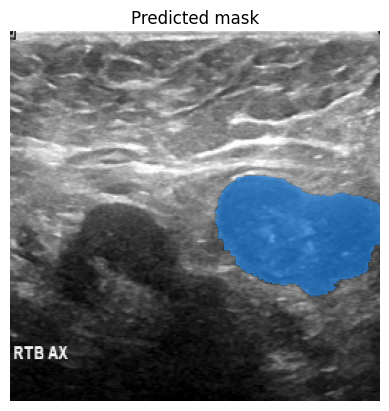

In [ ]:
def show_mask(mask, ax, random_color=False):
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
    else:
        color = np.array([30/255, 144/255, 255/255, 0.6])
    h, w = mask.shape[-2:]
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    ax.imshow(mask_image)

fig, axes = plt.subplots()

axes.imshow(np.array(image))
show_mask(medsam_seg, axes)
axes.title.set_text(f"Predicted mask")
axes.axis("off")

Compare this to the ground truth segmentation:

(-0.5, 255.5, 255.5, -0.5)

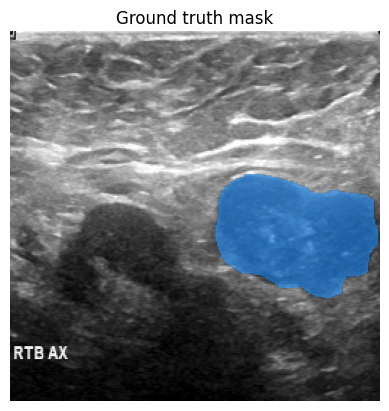

In [ ]:
fig, axes = plt.subplots()

axes.imshow(np.array(image))
show_mask(ground_truth_mask, axes)
axes.title.set_text(f"Ground truth mask")
axes.axis("off")

## Legacy

The code below was used during the creation of this notebook, but was eventually not used anymore.

In [ ]:
# upscaled_masks = postprocess_masks(low_res_masks.squeeze(1), batch["reshaped_input_sizes"][0].tolist(), batch["original_sizes"][0].tolist()).to(device)
# predicted_masks = normalize(threshold(upscaled_masks, 0.0, 0)).squeeze(1)
# loss = loss_fn(predicted_masks, ground_truth_masks)